# kNN 실습 - 농구선수의 게임 데이터를 활용한 포지션 예측

## 1. 문제 정의

NBA 농구선수들의 게임 기록을 데이터로 사용해 특정 농구선수의 포지션 예측하기

## 2. 데이터 획득

2017년 NBA 농구선수의 실제 데이터 사용하기 -> 2017년도 NBA 선수 게임 통계에서 수집

In [2]:
import pandas as pd

In [3]:
#데이터 수집하기
df = pd.read_csv('data/csv/basketball_stat.csv')
df

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5
...,...,...,...,...,...,...,...,...
95,Nikola Vucevic,C,0.3,6.1,10.4,2.8,1.0,1.0
96,Dwyane Wade,SG,0.8,6.2,4.5,3.8,1.4,0.7
97,Dion Waiters,SG,1.8,4.3,3.3,4.3,0.9,0.4
98,Hassan Whiteside,C,0.0,7.0,14.1,0.7,0.7,2.1


In [4]:
#수집된 데이터 샘플 확인
df.head()

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5


In [55]:
# 데이터 설명
basket = pd.DataFrame({
    '약어':['Player', 'Pos', '3P', '2P', 'TRB', 'AST','STL','BLK'],
    '설명':['선수 이름', '포지션', '한 경기 평균 3점슛 성공 횟수', '한 경기 평균 2점슛 성공 횟수', '한 경기 평균 리바운드 성공 횟수', '한 경기 평균 어시스트 성공 횟수','한 경기 평균 스틸 성공 횟수','한 경기 평균 블로킹 성공 횟수']
})
basket = basket.set_index('약어')
basket

,설명
약어,
Player,선수 이름
Pos,포지션
3P,한 경기 평균 3점슛 성공 횟수
2P,한 경기 평균 2점슛 성공 횟수
TRB,한 경기 평균 리바운드 성공 횟수
AST,한 경기 평균 어시스트 성공 횟수
STL,한 경기 평균 스틸 성공 횟수
BLK,한 경기 평균 블로킹 성공 횟수


In [5]:
#포지션 개수 확인
df.Pos.value_counts()

SG    50
C     50
Name: Pos, dtype: int64

- SG : 슈팅가드 포지션
    - 코트 내에서 3점슛 등 장거리에서 슛을 해서 점수를 얻는 역할
- C : 센터
    - 골대, 포스트 근처에서 슛을 블로킹하고, 리바운드하며, 공을 바깥으로 빼줘서 공격 찬스를 만들기도 하며, 골대 근처에서 2점슛으로 득점하기도 함

### ❗**특징(feature) 설정**

### 센터와 슈팅가드의 역할을 바탕으로 필요한 속성과 불필요한 속성 구분하기
-> 슈팅가드와 센터를 분별할 수 있는 속성 고르기

In [53]:
feature = pd.DataFrame({
    '약어':['3P', '2P', 'TRB', 'AST', 'STL', 'BLK'],
    '필요/불필요':['O', 'X', 'O', 'X', 'X', 'O'],
    '이유':['슈팅가드의 주요 역할은 3점슛 득점을 하는 것이며, 센터의 역할은 3점슛 ',
         '슈팅가드와 센터 모두 2점 득점을 많이 한다. 분별력이 없는 속성임',
         '센터는 슈팅가드보다 리바운드의 개수가 많을 것이기에 분별력 있는 속성',
         '슈팅가드와 센터 모두 어시스트를 많이 한다. 포지션과 상관 없는 속성',
         '슈팅가드와 센터 모두 스틸을 많이 한다. 분별력이 없는 속성',
         '센터는 슈팅가드에 비해 블로킹의 횟수가 많을 것이기에 분별력 있는 속성임']
})
feature = feature.set_index('약어')
feature

,필요/불필요,이유
약어,,
3P,O,"슈팅가드의 주요 역할은 3점슛 득점을 하는 것이며, 센터의 역할은 3점슛"
2P,X,슈팅가드와 센터 모두 2점 득점을 많이 한다. 분별력이 없는 속성임
TRB,O,센터는 슈팅가드보다 리바운드의 개수가 많을 것이기에 분별력 있는 속성
AST,X,슈팅가드와 센터 모두 어시스트를 많이 한다. 포지션과 상관 없는 속성
STL,X,슈팅가드와 센터 모두 스틸을 많이 한다. 분별력이 없는 속성
BLK,O,센터는 슈팅가드에 비해 블로킹의 횟수가 많을 것이기에 분별력 있는 속성임


### ------> 하지만 이는 가설일 뿐. 이 가설을 입증할 근거가 부족하므로 데이터 시각화를 통해 사실성을 입증함

## 3. 데이터 시각화

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#%matplotlib inline : notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 함

### - x축 : 스틸, y축 : 2점슛 그래프 상에서 슈팅가드와 센터 데이터의 분포도

C:\Users\ksjpt\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'STL and 2P in 2d plane')

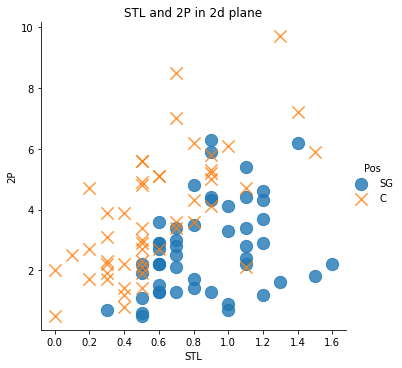

In [12]:
#스틸, 2점슛 데이터 시각화
sns.lmplot('STL', '2P', data=df, fit_reg=False, # x축, y축, 데이터, 노라인
          scatter_kws={"s":150},  # 좌표 상의 점의 크기
          markers=["o", "x"], # 점 모양
          hue="Pos") # 예측값
# 제목
plt.title('STL and 2P in 2d plane')

### - x축 : 어시스트, y축 : 2점슛 그래프 상에서 슈팅가드와 센터 데이터의 분포도

C:\Users\ksjpt\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'AST and 2P in 2d plane')

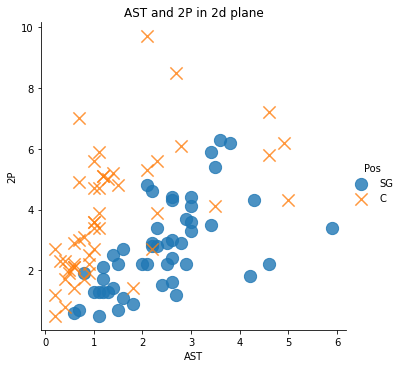

In [13]:
#어시스트, 2점슛 데이터 시각화
sns.lmplot('AST', '2P', data=df, fit_reg=False, # x축, y축, 데이터, 노라인
          scatter_kws={"s":150},  # 좌표 상의 점의 크기
          markers=["o", "x"], # 점 모양
          hue="Pos") # 예측값
# 제목
plt.title('AST and 2P in 2d plane')

### ✔알 수 있는 점: 가설과 같이 2점슛, 어시스트, 스틸의 속성 --> 슈팅가드와 센터의 경계가 근접해 분류하기 모호함

### - x축 : 블로킹, y축 : 3점슛 그래프 상에서 슈팅가드와 센터 데이터의 분포도

C:\Users\ksjpt\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'BLK and 3P in 2d plane')

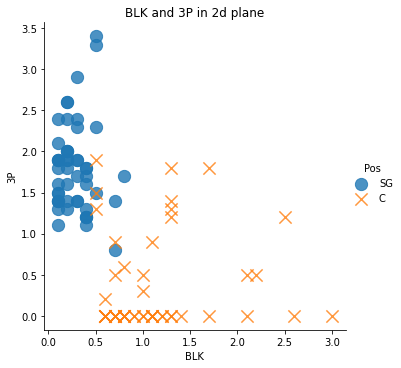

In [15]:
# 블로킹, 3점슛 데이터 시각화
sns.lmplot('BLK', '3P', data=df, fit_reg=False, # x축, y축, 데이터, 노라인
          scatter_kws={"s":150},  # 좌표 상의 점의 크기
          markers=["o", "x"], # 점 모양
          hue="Pos") # 예측값
# 제목
plt.title('BLK and 3P in 2d plane')

### - x축 : 리바운드, y축 : 3점슛 그래프 상에서 슈팅가드와 센터 데이터의 분포도

C:\Users\ksjpt\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'TRB and 3P in 2d plane')

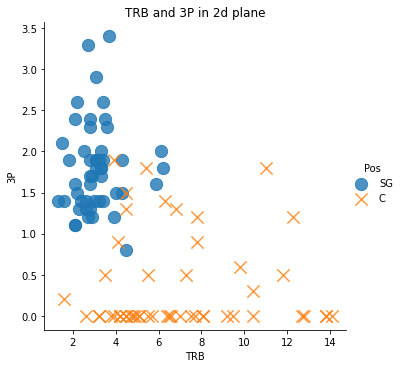

In [16]:
# 블로킹, 3점슛 데이터 시각화
sns.lmplot('TRB', '3P', data=df, fit_reg=False, # x축, y축, 데이터, 노라인
          scatter_kws={"s":150},  # 좌표 상의 점의 크기
          markers=["o", "x"], # 점 모양
          hue="Pos") # 예측값
# 제목
plt.title('TRB and 3P in 2d plane')

## 4. 데이터 다듬기

In [17]:
# 분별력이 없는 특징(feature) 제거 - 2점슛, 어시스트, 스틸 제거
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True) 
    # aixs=0(index), aixs=1(columns)
    # inplace=True : 기존 df에 덮어쓰기

In [18]:
df.head() #다듬어진 데이터 조회

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


## 5. 데이터 나누기

- 학습 데이터 , 테스트 데이터 나누기

In [19]:
# 사이키런의 train_test_split을 사용하면 코드 한 줄로 손쉽게 데이터를 나눌 수 있다
from sklearn.model_selection import train_test_split

In [20]:
# 다듬어진 데이터에서 20% -> 테스트 데이터test, 80% -> 학습 데이터train
train, test = train_test_split(df, test_size=0.2)

In [22]:
train.shape[0] #학습 데이터 개수

80

In [23]:
test.shape[0] #테스트 데이터 개수

20

80개의 학습 데이터 속성을 사용해 20개의 테스트 데이터의 포지션을 예측하기

# 6. 최적의 kNN 파라미터 찾기

파라미터 : 1개 - 이웃의 개수(k)
- k에 따라 모델의 예측값도 달라지므로 예측값이 가장 높은 **최적의 k** 찾기가 중요!!!

**검증 데이터를 사용해 가장 예측율이 높은 k값 찾기**
- 사이킷런의 train_test_split으로 학습 데이터train --> 학습 데이터 + 검증데이터 나누고 검증데이터의 레이블과 kNN 알고리즘 모델의 예측값 비교하기

*이번 예제에서는*
- 사이킷런의 cross_val_score 사용해 kNN 모델의 교차 검증(cross validation) 수행하기
- 교차 검증 : k-fold 교차 검증(기존 데이터를 k개로 나눠서 k번 정확도를 검증하는 방법)

In [34]:
# kNN 라이브러리 추가
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [35]:
# 최적의 k를 찾기 위해 교차 검증을 수행할 k의 범위를 3부터 학습 데이터 절반까지 지정
max_k_range = train.shape[0] // 2     #절반까지
k_list = []
for i in range(3, max_k_range, 2): # 3부터 절반까지 홀수만
    k_list.append(i)

cross_validation_scores = []       # 교차 검증 점수 (정확도)
x_train = train[['3P', 'BLK', 'TRB']]
y_train = train[['Pos']]

# 교차 검증(10-fold)을 각 k를 대상으로 수행해 검증 결과를 저장
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train.values.ravel(), cv=10,
                            scoring='accuracy')
    cross_validation_scores.append(scores.mean())    # 정확도의 평균 저장
    
cross_validation_scores

[0.95,
 0.9125,
 0.9125,
 0.925,
 0.9125,
 0.9125,
 0.9125,
 0.9,
 0.9,
 0.9,
 0.9,
 0.8625,
 0.8375,
 0.8375,
 0.8375,
 0.825,
 0.825,
 0.825,
 0.8]

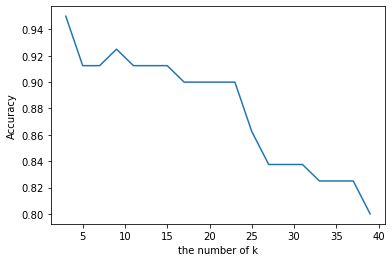

In [36]:
# k에 따른 정확도 시각화
plt.plot(k_list, cross_validation_scores)
plt.xlabel('the number of k')
plt.ylabel('Accuracy')
plt.show()

**알 수 있는 점**
- 최적의 k : 3
- k가 25를 넘으면 정확도가 급격히 떨어짐

In [37]:
# 가장 예측율이 높은 k를 선정
optimal_k = k_list[cross_validation_scores.index(max(cross_validation_scores))]
print("The best number of k : " + str(optimal_k))

The best number of k : 3


## 7. 모델 테스트

- 분별력이 있다고 판단된 3점슛, 블로킹, 리바운드 속성으로 kNN 모델 학습 -> 테스트

In [43]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)

# 학습에 사용될 속성을 지정
x_train = train[['3P', 'BLK', 'TRB']]
# 선수 포지션을 예측할 값으로 지정
y_train = train[['Pos']]

# kNN 모델 학습
knn.fit(x_train, y_train.values.ravel())

#테스트 데이터에서 분류를 위해 사용될 속성을 지정
x_test = test[['3P', 'BLK', 'TRB']]
# 선수 포지션에 대한 정답을 지정
y_test = test[['Pos']]

# 테스트 시작
pred = knn.predict(x_test)

# 모델 예측 정확도(accuracy) 출력
print("accuracy : " + str(accuracy_score(y_test.values.ravel(), pred)))

accuracy : 0.9


In [44]:
# 실제 데이터가 어떻게 분류되었는지 확인하고 싶으면
comparison = pd.DataFrame({
    "예측" : pred,
    "실제값" : y_test.values.ravel()
})
comparison

,예측,실제값
0,C,C
1,C,C
2,C,C
3,SG,SG
4,SG,SG
5,C,C
6,C,C
7,C,C
8,SG,C
9,C,C


# 성공적으로 예측!